In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from shapely.geometry import LineString, Point, Polygon, MultiPoint
import matplotlib.pyplot as plt

import geopandas as gpd
from pyproj import CRS
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import netCDF4 as nc
import ncdump
import shapely
shapely.speedups.enabled

%matplotlib inline


In [2]:
# IMERG data folder
IMERG_folder = '/home/lzhou/Precipitation/IMERG/'

# load track nodes that are within 500km of China boundary
infile = '/home/lzhou/Precipitation/Precipitation_Scripts/Output/CMA_Tracks_Nodes_500km_wgs84.shp'
nodes = gpd.read_file(infile)

In [96]:
# check dimensions from IMERG data (ds)
#lons = ds['lon'][:]
#lats = ds['lat'][:]
#precip = ds['precipitationCal'][0,:,:]
#lat1, lon1 = np.meshgrid(lats, lons)
#lon2, lat2 = np.meshgrid(lons, lats)

#print(np.shape(lat1),np.shape(lon1))
#print(np.shape(lat2),np.shape(lat2))
#print(np.shape(precip))

# get the extent of rainfall area, for later use in subset IMERG data
minx, miny, maxx, maxy = nodes.geometry.total_bounds
minx = minx-5;miny=miny-5;maxx=maxx+5;maxy=maxy+5
#print(minx,miny,maxx,maxy)

#Prepare coordinates for precipitation data

lons1 = np.arange(-179.95,180,0.1)
lats1 = np.arange(-89.95,90,0.1)

idx2 = int((maxx-lons1[0])/0.1)
#print(lons1[idx2],maxx)
idx1 = int((minx-lons1[0])/0.1)
#print(lons1[idx1],minx)
idy2 = int((maxy-lats1[0])/0.1)
#print(lats[idy2],maxy)
idy1 = int((miny-lats1[0])/0.1)
#print(lats[idy1],miny)

latitude = lats1[idy1:idy2+1]
longitude = lons1[idx1:idx2+1]
lat, lon = np.meshgrid(latitude,longitude)
lon1d = np.reshape(lon,-1)
lat1d = np.reshape(lat,-1)

print('lat: ',len(latitude),lat.shape)
print('lon: ',len(longitude),lon.shape)

lat:  499 (561, 499)
lon:  561 (561, 499)


In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
china = world[world.name=='China'].copy()

In [17]:
init_epsg = 4326

In [64]:
#m=china.boundary.plot()
#nodes[(nodes.Year==2018)&(nodes.InYearID==9)].plot(ax=m)
track = nodes[(nodes.Year==2019)&(nodes.InYearID==12)].reset_index(drop=True)
#print(track.head(1))
#print(track.tail(1))

In [65]:
# get list of IMERG files, sorted.
##
#"3B-DAY.MS.MRG.3IMERG.20011030-S000000-E235959.V06.nc4"
track['filename'] = track['Year']*10000+track['Month']*100+track['Day']
track['filename'] = track['filename'].astype('str')
filenames = track.filename.unique()

test=np.array([lat1d,lon1d,precip1d])

df = pd.DataFrame(test,columns=['lat','lon','precip'])
#precip_daily['Precipitation']=precip1d
df['geometry'] = df.apply(lambda x: Point((float(x.lon),float(x.lat))),axis=1)
df = gpd.GeoDataFrame(df,geometry='geometry')
df.head()

df.crs = CRS.from_epsg(4326)

#sns.color_palette("light:b", as_cmap=True)
m = df.plot(column='precip',cmap='Blues',figsize=(8,8),legend=True)
china.boundary.plot(color='black',ax=m)
track_buffer.boundary.plot(ax=m,color='yellow',linewidth=1)

In [81]:
# check dimensions from IMERG data (ds)
lons = ds['lon'][:]
lats = ds['lat'][:]
precip = ds['precipitationCal'][0,:,:]
lat1, lon1 = np.meshgrid(lats, lons)
lon2, lat2 = np.meshgrid(lons, lats)

print(np.shape(lat1),np.shape(lon1))
print(np.shape(lat2),np.shape(lat2))
print(np.shape(precip))


(3600, 1800) (3600, 1800)
(1800, 3600) (1800, 3600)
(3600, 1800)


In [66]:
##
#filename = "3B-DAY.MS.MRG.3IMERG."+track.loc[0,'filename']+"-S000000-E235959.V06.nc4"
first_call = 1
for ii in np.arange(0,len(filenames)):
    filename = "3B-DAY.MS.MRG.3IMERG."+filenames[ii]+"-S000000-E235959.V06.nc4"
    infile = os.path.join(IMERG_folder,filename)
    print(infile, ' ',os.path.isfile(infile))

# find files that are needed (not use)
#firstday=dt.date(2000,6,1)
#startdate = dt.date(track.loc[0,'Year'],track.loc[0,'Month'],track.loc[0,'Day'])
#startdate = dt.date(2001,6,1)
#deltaday = startdate-firstday
#delta = deltaday.days
#sort_files[delta]
#fn = os.path.join(infolder,sort_files[delta])
#print(fn)

    ds = nc.Dataset(infile,'r')
    precip = ds['precipitationCal'][0,idx1:idx2+1,idy1:idy2+1]
    precip1d = np.reshape(precip,-1)
    dummy = np.array([lat1d,lon1d,precip1d])
    print(dummy.shape)
    df = pd.DataFrame(dummy.T,columns=['lat','lon','precip'])
    df['Time'] = filenames[ii]
    df['CMAID'] = track.loc[0,'CMAID']
    if first_call == 1:
        precip_daily = df.copy()
        first_call = 0
    else: 
        precip_daily = precip_daily.append(df)

/home/lzhou/Precipitation/IMERG/3B-DAY.MS.MRG.3IMERG.20190808-S000000-E235959.V06.nc4   True
(3, 279939)
/home/lzhou/Precipitation/IMERG/3B-DAY.MS.MRG.3IMERG.20190809-S000000-E235959.V06.nc4   True
(3, 279939)
/home/lzhou/Precipitation/IMERG/3B-DAY.MS.MRG.3IMERG.20190810-S000000-E235959.V06.nc4   True
(3, 279939)
/home/lzhou/Precipitation/IMERG/3B-DAY.MS.MRG.3IMERG.20190811-S000000-E235959.V06.nc4   True
(3, 279939)
/home/lzhou/Precipitation/IMERG/3B-DAY.MS.MRG.3IMERG.20190812-S000000-E235959.V06.nc4   True
(3, 279939)
/home/lzhou/Precipitation/IMERG/3B-DAY.MS.MRG.3IMERG.20190813-S000000-E235959.V06.nc4   True
(3, 279939)
/home/lzhou/Precipitation/IMERG/3B-DAY.MS.MRG.3IMERG.20190814-S000000-E235959.V06.nc4   True
(3, 279939)


In [67]:
precip_daily['geometry'] = precip_daily.apply(lambda x: Point((float(x.lon),float(x.lat))),axis=1)
precip_daily = gpd.GeoDataFrame(precip_daily,geometry='geometry')
precip_daily.crs = CRS.from_epsg(init_epsg)

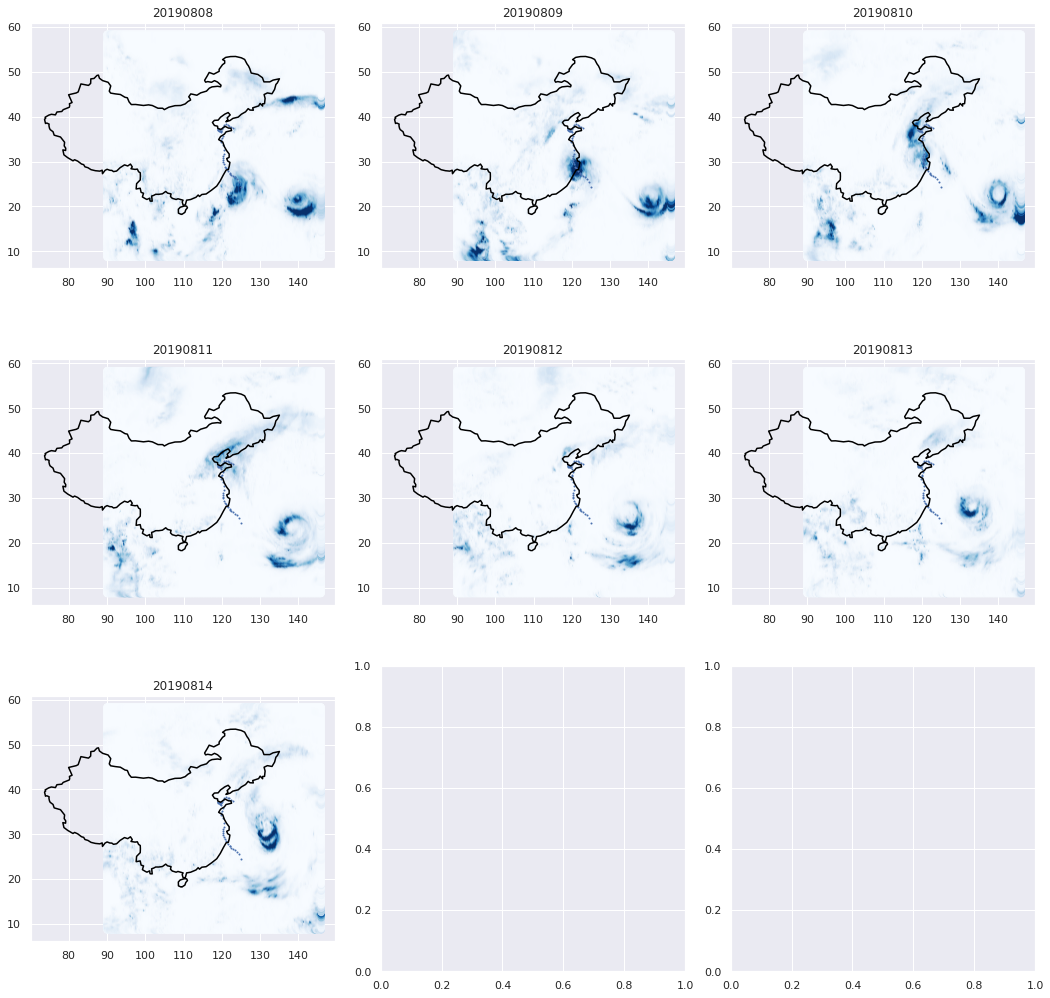

In [97]:
fig, axs = plt.subplots(3,3,figsize=(18,18))
fig.subplots_adjust(hspace =0.1, wspace=0.15)
axs = axs.ravel()
jj = 0
grouped = precip_daily.groupby('Time')
for name, group in grouped:
    #print(name)
    m = axs[jj]
    group.plot(column='precip',cmap='Blues',vmin=0,vmax=200,ax=m)
    china.boundary.plot(color='black',ax=m)
    track.plot(ax=m,markersize=1)
    m.title.set_text(name)

    jj = jj+1
    
fig.savefig('2019_Lekima2.png')

In [104]:
#CMPA 3km data
CMPA_folder = '/home/lzhou/Precipitation/CMPA/CMPA_3km/201908'
files = os.listdir(CMPA_folder)


In [105]:
files

['R01H_FRT_2019080405.npy',
 'R01H_FRT_2019080512.npy',
 'R01H_FRT_2019080319.npy',
 'R01H_FRT_2019082116.npy',
 'R01H_FRT_2019081216.npy',
 'R01H_FRT_2019081712.npy',
 'R01H_FRT_2019083018.npy',
 'R01H_FRT_2019082405.npy',
 'R01H_FRT_2019081317.npy',
 'R01H_FRT_2019081722.npy',
 'R01H_FRT_2019080302.npy',
 'R01H_FRT_2019081303.npy',
 'R01H_FRT_2019080620.npy',
 'R01H_FRT_2019080511.npy',
 'R01H_FRT_2019082301.npy',
 'R01H_FRT_2019080114.npy',
 'R01H_FRT_2019081900.npy',
 'R01H_FRT_2019081002.npy',
 'R01H_FRT_2019080516.npy',
 'R01H_FRT_2019082108.npy',
 'R01H_FRT_2019081202.npy',
 'R01H_FRT_2019081922.npy',
 'R01H_FRT_2019081914.npy',
 'R01H_FRT_2019082213.npy',
 'R01H_FRT_2019083103.npy',
 'R01H_FRT_2019082700.npy',
 'R01H_FRT_2019082921.npy',
 'R01H_FRT_2019081618.npy',
 'R01H_FRT_2019081106.npy',
 'R01H_FRT_2019082312.npy',
 'R01H_FRT_2019081021.npy',
 'R01H_FRT_2019081620.npy',
 'R01H_FRT_2019082614.npy',
 'R01H_FRT_2019080717.npy',
 'R01H_FRT_2019080215.npy',
 'R01H_FRT_201908151